In [7]:
import pandas as pd
from googleapiclient.discovery import build
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import re
import json


# API-Schlüssel und YouTube-Dienst initialisieren
json_file_path = 'credentials.json'
with open(json_file_path, 'r') as file:
    data = json.load(file)
    api_key = data['api_key']


youtube = build('youtube', 'v3', developerKey=api_key)

def search_videos(query, max_results=1000):
    videos = []
    next_page_token = None
    
    while len(videos) < max_results:
        request = youtube.search().list(
            q=query,
            part='snippet',
            type='video',
            maxResults=min(50, max_results - len(videos)),
            pageToken=next_page_token
        )
        response = request.execute()
        
        for item in response['items']:
            video_data = {
                'video_id': item['id']['videoId'],
                'title': item['snippet']['title'],
                'description': item['snippet']['description'],
                'channel_title': item['snippet']['channelTitle'],
                'publish_time': item['snippet']['publishTime']
            }
            if re.search(r'\bEURO 2024\b', video_data['title'], re.IGNORECASE):
                videos.append(video_data)
        
        next_page_token = response.get('nextPageToken')
        if not next_page_token:
            break
    
    return videos

def get_video_statistics(video_ids):
    stats = []
    for i in range(0, len(video_ids), 50):
        request = youtube.videos().list(
            part='statistics',
            id=','.join(video_ids[i:i+50])
        )
        response = request.execute()
        
        for item in response['items']:
            stats.append({
                'video_id': item['id'],
                'view_count': int(item['statistics'].get('viewCount', 0)),
                'like_count': int(item['statistics'].get('likeCount', 0))
            })
    
    return stats

# Nach Videos suchen, die "EURO 2024" im Titel enthalten
query = 'EURO 2024'
videos = search_videos(query, max_results=1000)

# Video-IDs extrahieren
video_ids = [video['video_id'] for video in videos]

# Video-Statistiken abrufen
statistics = get_video_statistics(video_ids)

# Statistiken zu den Videos hinzufügen
for video in videos:
    for stat in statistics:
        if video['video_id'] == stat['video_id']:
            video['view_count'] = stat['view_count']
            video['like_count'] = stat['like_count']
            break

# Daten in ein DataFrame umwandeln und anzeigen
df = pd.DataFrame(videos)

# DataFrame in eine CSV-Datei speichern
df.to_csv('data/euro_2024_videos.csv', index=False)


In [10]:
import pandas as pd
import sqlite3

# CSV-Datei laden
csv_file_path = 'data/euro_2024_videos.csv'
df = pd.read_csv(csv_file_path)

# SQLite-Datenbank erstellen und eine Verbindung herstellen
db_file_path = 'data/euro_2024_videos.db'
conn = sqlite3.connect(db_file_path)
cursor = conn.cursor()

# Tabelle erstellen (falls sie noch nicht existiert)
create_table_query = '''
CREATE TABLE IF NOT EXISTS videos (
    video_id TEXT PRIMARY KEY,
    title TEXT,
    description TEXT,
    channel_title TEXT,
    publish_time TEXT,
    view_count INTEGER,
    like_count INTEGER
)
'''
cursor.execute(create_table_query)

# Daten aus dem DataFrame in die SQLite-Tabelle einfügen
for row in df.itertuples(index=False):
    cursor.execute('''
        INSERT OR REPLACE INTO videos (video_id, title, description, channel_title, publish_time, view_count, like_count)
        VALUES (?, ?, ?, ?, ?, ?, ?)
    ''', row)

# Änderungen speichern und Verbindung schließen
conn.commit()
conn.close()


In [2]:
import pandas as pd
import sqlite3

# Pfad zur SQLite-Datenbankdatei
db_file_path = 'data/euro_2024_videos.db'

# Verbindung zur SQLite-Datenbank herstellen
conn = sqlite3.connect(db_file_path)

# Abfrage ausführen, um alle Zeilen der Tabelle 'videos' anzuzeigen
query = "SELECT * FROM videos"
df_query_result = pd.read_sql_query(query, conn)

# Verbindung schließen
conn.close()

# Ergebnisse anzeigen
df_query_result.head()  # Zeigt die ersten 5 Zeilen der Tabelle an


,video_id,title,description,channel_title,publish_time,view_count,like_count
0,TqNWJ6-bXw4,Reacting To The OFFICIAL Portugal EURO 2024 Sq...,AA9SKILLZ TALKS ABOUT PORTUGAL SQUAD FOR EURO ...,MoreAA9Skillz,2024-05-28T17:00:17Z,22307,1362
1,X4kVdciCv9g,My EURO 2024 Prediction,EURO 2024 in Germany is getting closer and now...,Fiago,2024-04-09T17:40:10Z,200198,9393
2,Fl4IGS5KqAY,France Announce Official Euro 2024 Squad,None,Pêche Football,2024-05-17T06:56:28Z,1144578,63181
3,C5B22ONbFrc,"MEDUZA, OneRepublic, Leony - Fire (Official UE...",The Official Video for Fire (Official UEFA EUR...,MeduzaVEVO,2024-05-24T04:00:06Z,288936,13737
4,4Q42klKvQQI,Official Euro 2024 Groups (UPDATED) 🇪🇺,None,Pêche Football,2024-03-28T22:25:58Z,312112,24749


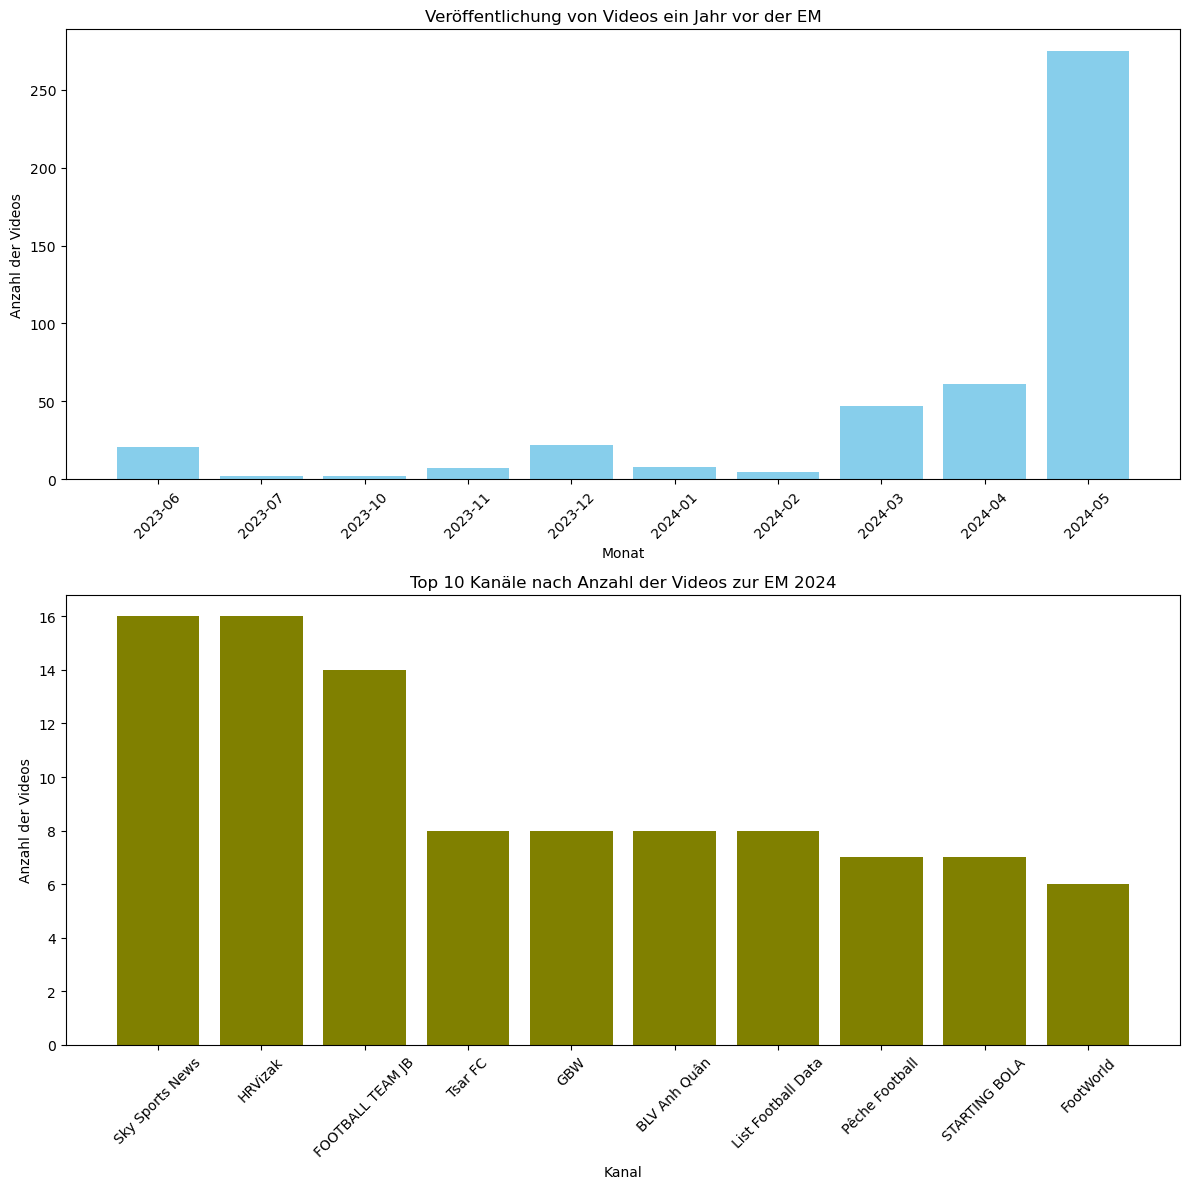

In [1]:
import warnings
import pandas as pd
import matplotlib.pyplot as plt

# CSV-Datei einlesen
csv_file_path = 'data/euro_2024_videos.csv'
df = pd.read_csv(csv_file_path)

# Veröffentlichungszeit in datetime umwandeln
df['publish_time'] = pd.to_datetime(df['publish_time'])

# Filter für das Startdatum anwenden
start_date = '2023-06-14'
filtered_df = df[df['publish_time'] >= start_date].copy()

# Unterdrücken der UserWarning
with warnings.catch_warnings():
    warnings.simplefilter("ignore", UserWarning)
    filtered_df['year_month'] = filtered_df['publish_time'].dt.to_period('M')

publish_counts = filtered_df['year_month'].value_counts().sort_index()

# Daten für das Säulendiagramm vorbereiten
labels = publish_counts.index.astype(str)
counts = publish_counts.values

# Top 10 Kanäle mit den meisten Videos ermitteln
channel_counts = filtered_df['channel_title'].value_counts().nlargest(10)

# Daten für das Säulendiagramm der Top 10 Kanäle vorbereiten
top_channels = channel_counts.index
top_channel_counts = channel_counts.values

# Erstellen der Subplots
fig, axs = plt.subplots(2, 1, figsize=(12, 12))

# Erstes Säulendiagramm (Veröffentlichung von Videos nach Monat)
axs[0].bar(labels, counts, color='skyblue')
axs[0].set_xlabel('Monat')
axs[0].set_ylabel('Anzahl der Videos')
axs[0].set_title('Veröffentlichung von Videos ein Jahr vor der EM')
axs[0].tick_params(axis='x', rotation=45)

# Zweites Säulendiagramm (Top 10 Kanäle nach Anzahl der Videos)
axs[1].bar(top_channels, top_channel_counts, color='olive')
axs[1].set_xlabel('Kanal')
axs[1].set_ylabel('Anzahl der Videos')
axs[1].set_title('Top 10 Kanäle nach Anzahl der Videos zur EM 2024')
axs[1].tick_params(axis='x', rotation=45)

# Layout anpassen und anzeigen
plt.tight_layout()
plt.show()
fig.savefig('static/graphics/euro_2024_analysis.png')

Korrelation zwischen Views und Likes: 0.822568781945422
p-Wert: 1.1618323501692401e-124


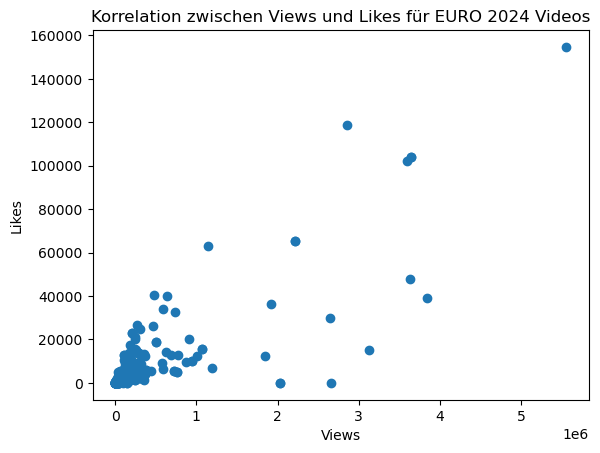

<Figure size 640x480 with 0 Axes>

In [9]:
from scipy.stats import pearsonr
import pandas as pd
import matplotlib.pyplot as plt

# CSV-Datei lesen
df = pd.read_csv('data/euro_2024_videos.csv')

# Berechnung der Korrelation und des p-Werts zwischen Video-Views und Likes
view_counts = df['view_count'].astype(float)
like_counts = df['like_count'].astype(float)

correlation, p_value = pearsonr(view_counts, like_counts)
print(f'Korrelation zwischen Views und Likes: {correlation}')
print(f'p-Wert: {p_value}')

# Daten visualisieren
plt.scatter(df['view_count'], df['like_count'])
plt.xlabel('Views')
plt.ylabel('Likes')
plt.title('Korrelation zwischen Views und Likes für EURO 2024 Videos')
plt.show()

plt.savefig('static/graphics/euro_2024_correlation.jpg')